# EXAMPLE ON HOW TO GET THE HYBRID BIAS FIELD-LEVEL RESULTS FROM MAP2MAP

Hellooooooo Kate! I hope everything is going wonderful! 

Here I summarise the codes I used to get the field level results with the map2map emulator.

## Some steps prior to computing the fields of the hybrid model

1. First, one needs to have the displacement fields from a Zeldovich simulation and (in case you'd like to compare against a full N-body) from their correspondant N-body simulation, and the linear density field of such simulation (this is for later). Since the map2map emulator was trained on the Quijote simulations, I have prepared one such simulations in the following folder at the atlas cluster (I hope you have access to it, otherwise let me know and I will send you the files):

**N-body displacement: /dipc_storage/mpelle/Yin_data/Fiducial/Quijote/200/**

**ZA displacement: /dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/**

**Linear density: /dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/den_200.npy**

(Note that /dipc_storage/ is called like that only from our node, atlas-248. From the normal atlas log-in nodes it is just called /dipc/).

2. Once you have the ZA displacement field, you will need to install the map2map emulator from Drew's github repository:

https://github.com/dsjamieson/map2map_emu/

3. To get the emulated displacement field, just run the line (changing the paths to wherever you have the files):

```shell
python m2m.py test --test-in-patterns "/dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/dis_200.npy" --test-tgt-patterns "/dipc_storage/mpelle/Yin_data/Fiducial/ZA/200/dis_200.npy" --in-norms "cosmology.dis" --tgt-norms "cosmology.dis" --crop 128 --crop-step 128 --pad 48 --model d2d.StyledVNet --batches 1 --loader-workers 7 --load-state "map2map/weights/d2d_weights.pt" --callback-at "/scratch/mpelle/CodesPostdocDIPC/map2map_emu/" --test-style-pattern "/scratch/mpelle/CodesPostdocDIPC/map2map_emu/style_fyle.txt"
```
I know this is a very confusing line if it is the first time that you see it. Let me know if you have any trouble. The "style_fyle.txt" is a file that the user has to create containing the Om value of the simulation. Since I used the Quijote fiducial cosmology for this example, it is Om=0.3175. It only contains the number, not the "Om=".
The output of this code will be writen in a file called "._out.npy" so you won't be able to see it with a simple ls!!! Once you run it, just move it with the name you prefer, in our case:
```shell
mv ._out.npy emu_disp.npy
```
Now that we have the emulation and the N-body result, we can compute the fields. 

## Computing the emulated fields 

1. We have to load some modules first and set uo a couple of options for the bacco code

In [1]:
import numpy as np
import bacco
import os
import copy
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import deepdish as dd

ngrid = 512 #1024 #512 #256 #128 #256 #1400
nmean=0.01
BoxSize=1000

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}})
bacco.configuration.update({'pknbody' : {'interlacing' : False}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

In [2]:
import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import utils


2024-07-19 16:27:07.400005: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 16:27:07.689159: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-19 16:27:07.690759: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 16:27:11.177525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-19 16:27:16.041186: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

2. We create a uniform grid of particles as the Initial Conditions of our emulated simulation

In [3]:
grid = bacco.visualization.uniform_grid(npix=ngrid, L=BoxSize, ndim=3, bounds=False)

3. We read the emulated displacement and move the particles

In [4]:
indicesLH = np.array([10,29,37,40,70,85,127,158,165,184,208,220,240,254,267,274,293,305,336,374,375,388,433,444,
                      464,502,534,542,574,598,605,628,652,663,676,700,702,721,737,762,809,822,825,837,853,864,882,
                      899,901,911,939,948,950,951,964,976,977,1016,1022,1041,1050,1060,1082,1091,1103,1114,1147,
                      1157,1173,1175,1219,1222,1299,1309,1314,1317,1331,1365,1372,1378,1391,1397,1418,1444,1459,
                      1510,1512,1513,1515,1517,1533,1553,1567,1568,1599,1622,1642,1657,1659,1667])
#i = 0
i = list(indicesLH).index(663) #in lbias emu bounds

#pred_disp = np.load('/dipc_storage/mpelle/Yin_data/Quijote/LH%04d/pred_pos_%04d.npy'%(indicesLH[i], indicesLH[i]))
pred_disp = np.load('/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/pred_pos_%04d.npy'%(indicesLH[i], indicesLH[i]))

pred_pos = bacco.scaler.add_displacement(None,
                             pred_disp,
                             box=BoxSize,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2024-07-19 16:27:24,122 bacco.scaler : Adding displacement field with a vel-factor=0.000000


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [5]:
'/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/pred_pos_%04d.npy'%(indicesLH[i], indicesLH[i])

'/cosmos_storage/home/mpelle/Yin_data/Quijote/LH0663/pred_pos_0663.npy'

Now we have the emulated positions coming from map2map :)

4. We take this emulated simulation and compute the fields that will be used for the hybrid model. To do this we also need the linear density field of the Quijote simulation.

We read the linear density field of the Quijote simulation:

In [6]:
#dens_yin = np.load('/dipc_storage/mpelle/Yin_data/Quijote/LH%04d/lin_den_%04d.npy'%(indicesLH[i], indicesLH[i]))
dens_yin = np.load('/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/lin_den_%04d.npy'%(indicesLH[i], indicesLH[i]))

Then initialise the hybrid bias class:

In [7]:
k_nyq = np.pi * ngrid / BoxSize

damping_scale = k_nyq

bmodel = bacco.BiasModel(sim=None, linear_delta=dens_yin[0], ngrid=ngrid, ngrid1=ngrid,
                         sdm=True, mode="dm", BoxSize=BoxSize,
                         npart_for_fake_sim=ngrid, damping_scale=damping_scale,
                         bias_model='expansion', deposit_method="cic",
                         use_displacement_of_nn=False, interlacing=False,
                         )

2024-07-19 16:27:25,957 bacco.BiasModel : Initialising Bias Model class ...


Ask the bias class to compute the bias fields in Lagrangian coordinates:

In [8]:
bias_fields = bmodel.bias_terms_lag()

2024-07-19 16:27:28,035 bacco.BiasModel : Computing delta_to_tidal_field with 12 threads...
2024-07-19 16:27:28,036 bacco.BiasModel : fttw plan
2024-07-19 16:27:28,037 bacco.BiasModel : Computing linear field ...
2024-07-19 16:27:28,038 bacco.BiasModel : Memory used: 6.972878848 Gigabytes
2024-07-19 16:27:28,044 bacco.BiasModel : fttw freqs
2024-07-19 16:27:28,045 bacco.BiasModel : tidk freqs
2024-07-19 16:27:34,131 bacco.BiasModel : ifft
2024-07-19 16:28:03,897 bacco.BiasModel : Computing laplacian ...
2024-07-19 16:28:03,899 bacco.BiasModel : Memory used: 11.810009088 Gigabytes
2024-07-19 16:28:05,141 bacco.BiasModel : Computing bias terms in lagrangian coords ...
2024-07-19 16:28:05,143 bacco.BiasModel : Memory used: 12.3466752 Gigabytes
2024-07-19 16:28:05,387 bacco.BiasModel : Computing delta squared ...
2024-07-19 16:28:05,389 bacco.BiasModel : Memory used: 12.883542016 Gigabytes
2024-07-19 16:28:06,479 bacco.BiasModel : Computing tidal component G2 with the given tidal field
202

Weight the emulated positions by the lagrangian fields: 

In [9]:
bias_terms_eul_pred=[]
for ii in range(0,len(bias_fields)):
    bias_terms_pred = bacco.statistics.compute_mesh(ngrid=ngrid, box=BoxSize, pos=pred_pos,
                              mass = (bias_fields[ii]).flatten(), deposit_method='cic',
                              interlacing=False)
    bias_terms_eul_pred.append(bias_terms_pred)
bias_terms_eul_pred = np.array(bias_terms_eul_pred)

2024-07-19 16:28:18,591 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:18,593 bacco.statistics : starting deposit 1
2024-07-19 16:28:20,425 bacco.statistics :  mesh done in 1.83 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 16:28:20,904 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:20,905 bacco.statistics : starting deposit 1
2024-07-19 16:28:22,699 bacco.statistics :  mesh done in 1.79 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 16:28:23,305 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:23,307 bacco.statistics : starting deposit 1
2024-07-19 16:28:25,022 bacco.statistics :  mesh done in 1.72 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 16:28:25,736 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:25,737 bacco.statistics : starting deposit 1
2024-07-19 16:28:27,374 bacco.statistics :  mesh done in 1.64 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 16:28:28,019 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:28,020 bacco.statistics : starting deposit 1
2024-07-19 16:28:29,822 bacco.statistics :  mesh done in 1.8 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


5. We repeat the same procedure but with the Quijote displacements to get the N-body results:

In [10]:
# seems like this was wrong, should go to the same index as above
sim_disp = np.load('/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/dis_%04d.npy'%(indicesLH[i], indicesLH[i]))
#sim_disp = np.load('/dipc_storage/mpelle/Yin_data/Fiducial/Quijote/200/dis_200.npy')
#sim_disp = np.load('/cosmos_storage/home/mpelle/Yin_data/Fiducial/Quijote/200/dis_200.npy')

sim_pos = bacco.scaler.add_displacement(None,
                             sim_disp,
                             box=BoxSize,
                             pos=grid.reshape(-1,3),
                             vel=None,
                             vel_factor=0,
                             verbose=True)[0]

2024-07-19 16:28:34,306 bacco.scaler : Adding displacement field with a vel-factor=0.000000


bacco.lss_scaler:  Adding LSS displacement: vel_factor=0.000000 mesh_dtype=4, use_vel=0, use_bias=0
bacco.lss_scaler:  Adding LSS displacement: looping over particles


In [11]:
bias_terms_eul_sim=[]
for ii in range(0,len(bias_fields)):
    bias_terms_sim = bacco.statistics.compute_mesh(ngrid=ngrid, box=BoxSize, pos=sim_pos,
                              mass = (bias_fields[ii]).flatten(), deposit_method='cic',
                              interlacing=False)
    bias_terms_eul_sim.append(bias_terms_sim)
bias_terms_eul_sim = np.array(bias_terms_eul_sim)

2024-07-19 16:28:36,753 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:36,754 bacco.statistics : starting deposit 1
2024-07-19 16:28:38,400 bacco.statistics :  mesh done in 1.65 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 16:28:38,997 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:38,998 bacco.statistics : starting deposit 1
2024-07-19 16:28:40,642 bacco.statistics :  mesh done in 1.65 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 16:28:41,246 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:41,247 bacco.statistics : starting deposit 1
2024-07-19 16:28:42,988 bacco.statistics :  mesh done in 1.74 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 16:28:43,625 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:43,626 bacco.statistics : starting deposit 1
2024-07-19 16:28:45,300 bacco.statistics :  mesh done in 1.67 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


2024-07-19 16:28:46,008 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-07-19 16:28:46,009 bacco.statistics : starting deposit 1
2024-07-19 16:28:47,748 bacco.statistics :  mesh done in 1.74 s


bacco.mesh : boxsize=1000.000000 ngrid=512, nthreads=12, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 512.0 Mb
bacco.mesh : binning of 134217728 particles (134217728 with mass)


Let's plot a couple of them to check that everything went as expected:

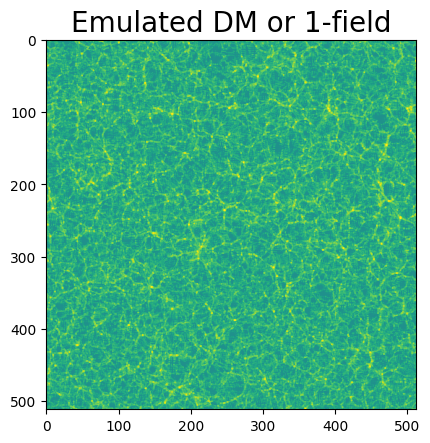

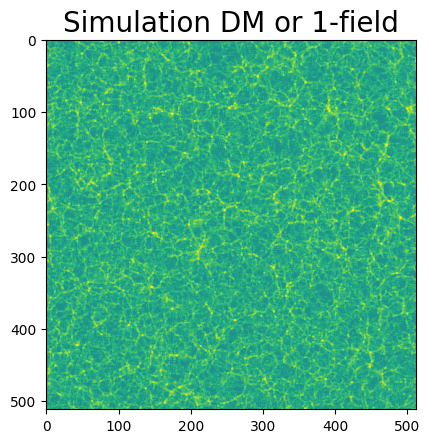

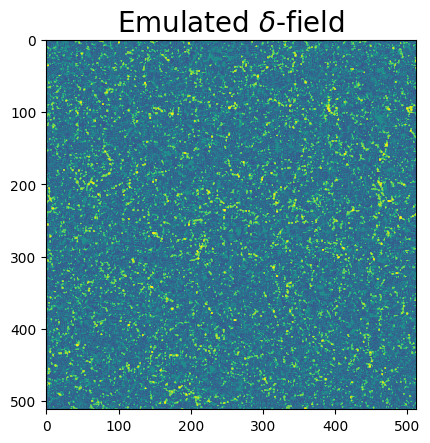

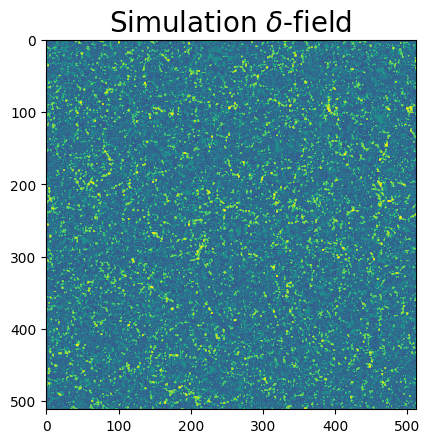

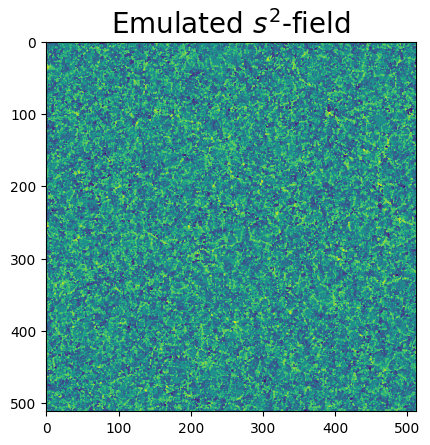

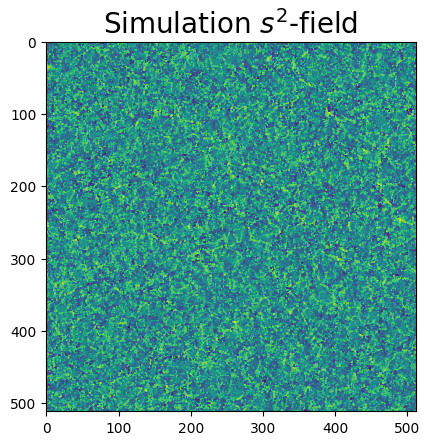

In [12]:
# Set normalisation
from matplotlib.colors import SymLogNorm
norm = SymLogNorm(linthresh=0.1, linscale=0.1, vmin=-100.0, vmax=100.0)

#Plot 1-term
plt.imshow(bias_terms_eul_pred[0][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated DM or 1-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[0][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation DM or 1-field', size=20)
plt.show()

#Plot delta-term
plt.imshow(bias_terms_eul_pred[1][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated $\delta$-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[1][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation $\delta$-field', size=20)
plt.show()

#Plot tidal-term
plt.imshow(bias_terms_eul_pred[3][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Emulated $s^2$-field', size=20)
plt.show()
plt.imshow(bias_terms_eul_sim[3][0][0,:,:], norm=norm)
#plt.colorbar()
plt.title(r'Simulation $s^2$-field', size=20)
plt.show()

#### Everything looks good so far! I am as surprised as you are :)

## Computing the emulated spectra

Let's see what the results are from a more quantitative point of view. Let's compute their power spectra and compare N-body versus emulated results.

1. We need to define the arguments for the power spectrum computation within bacco (but you can use any power spectrum calculator of course).

In [13]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
# Ob = 0.049
# Om = 0.3175
# hubble = 0.6711
# ns = 0.9624
# sigma8 = 0.834
# we should be reading in from the idx
fn_cosmo_params = '/cosmos_storage/home/mpelle/Yin_data/Quijote/LH%04d/param_%04d.txt'%(indicesLH[i], indicesLH[i])
Om, Ob, hubble, ns, sigma8 = np.loadtxt(fn_cosmo_params)

cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob,
        hubble=hubble,
        ns=ns,
        sigma8=sigma8,
        tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
print(cosmopars)

cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2024-07-19 16:28:52,571 bacco.cosmo :    initialization took 0.000 secs


{'omega_cdm': 0.27604999999999996, 'omega_baryon': 0.04625, 'hubble': 0.7015, 'ns': 0.9607, 'sigma8': 0.8311, 'tau': 0.0561, 'A_s': None, 'neutrino_mass': 0.0, 'w0': -1, 'wa': 0, 'tag': 'cosmo_BOSS'}


In [14]:

##################

# These are the important arguments of the P(k)
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':False,
                  'kmin':0.01,
                  'kmax':1,
                  'nbins':50,
                  'correct_grid':True,
                  'log_binning':True,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'compute_power2d':False}


#This is what I was talking about some corrections one can make to the P(k) computation
#Not very important though, ask Raul if you want to know more
lt_k = np.logspace(np.log10(np.pi / BoxSize), np.log10(2 * np.pi / BoxSize * ngrid), num=90)
pk_lpt = bacco.utils.compute_pt_15_basis_terms(cosmo_Quijote, expfactor=cosmo_Quijote.expfactor, wavemode=lt_k)

#Normalise the grid before P(k) computation
#one can normalise later too, I chose to do it here
norm=ngrid**3.
bias_terms_eul_norm_pred = bias_terms_eul_pred/norm


2024-07-19 16:28:53,231 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.274 secs
2024-07-19 16:28:53,235 bacco.cosmo :    created Pk(z=0) tab from k 0.0007014999999999996 to 100000.0 h/Mpc


## Load and setup emu

In [15]:
cosmo_params_emu_quijote = utils.cosmo_bacco_to_cosmo_baccoemu(cosmo_Quijote)

In [16]:
emu, emu_bounds, emu_param_names = utils.load_emu()
emu_bounds_dict = dict(zip(emu_param_names, emu_bounds))

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 whe

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...
Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.1.1

Nonlinear l-bias emulator loaded in memory.
HIIII


/dipc/kstoreyf/.conda/envs/bacemuenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
lt_k_emu = lt_k[lt_k<0.75]
_, pnn_emu = emu.get_nonlinear_pnn(k=lt_k_emu, **cosmo_params_emu_quijote)

2. And compute the power spectrum of the 15 auto and cross terms

In [18]:

#Compute a dummy variable with the 15 combinations of 5 distinct objects
import itertools
prod = np.array(list(itertools.combinations_with_replacement(np.arange(bias_terms_eul_pred.shape[0]),r=2)))

#Compute the P(k) of the 15 terms
power_all_terms_pred = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True
    print(ii, prod[ii])
    power_term_pred = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm_pred[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm_pred[prod[ii,1]],
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=True,
                                                    deconvolve_grid2=True,
                                                    **args_power)
    power_all_terms_pred.append(power_term_pred)


2024-07-19 16:29:05,187 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-07-19 16:29:05,190 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.002 secs


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.397188 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.357165 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000375 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:08,519 bacco.statistics :  ...done in 3.33 s
2024-07-19 16:29:08,520 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -1.08802e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.391611 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.402387 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000233 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:11,925 bacco.statistics :  ...done in 3.4 s
2024-07-19 16:29:11,926 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 5.40599e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.416175 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.365745 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000289 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:15,517 bacco.statistics :  ...done in 3.59 s
2024-07-19 16:29:15,518 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 9.97825e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.549679 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.449701 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000287 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:19,183 bacco.statistics :  ...done in 3.66 s
2024-07-19 16:29:19,187 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.423514 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.352389 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000267 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:22,548 bacco.statistics :  ...done in 3.36 s
2024-07-19 16:29:22,549 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.08802e-10 (grid1) -1.08802e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.440982 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.343048 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000316 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:25,938 bacco.statistics :  ...done in 3.39 s
2024-07-19 16:29:25,939 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.08802e-10 (grid1) 5.40599e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.377965 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.346085 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000303 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:29,527 bacco.statistics :  ...done in 3.59 s
2024-07-19 16:29:29,529 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.08802e-10 (grid1) 9.97825e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.516812 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.364139 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000241 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:33,237 bacco.statistics :  ...done in 3.71 s
2024-07-19 16:29:33,238 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.08802e-10 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.393700 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.364105 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000257 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:36,616 bacco.statistics :  ...done in 3.38 s
2024-07-19 16:29:36,617 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40599e-06 (grid1) 5.40599e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.441514 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.369140 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000456 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:39,990 bacco.statistics :  ...done in 3.37 s
2024-07-19 16:29:39,991 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40599e-06 (grid1) 9.97825e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.377978 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.355443 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000389 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:43,495 bacco.statistics :  ...done in 3.5 s
2024-07-19 16:29:43,496 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.40599e-06 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.523251 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.352821 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000234 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:46,997 bacco.statistics :  ...done in 3.5 s
2024-07-19 16:29:46,998 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97825e-06 (grid1) 9.97825e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.371845 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.348552 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000394 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:50,187 bacco.statistics :  ...done in 3.19 s
2024-07-19 16:29:50,188 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97825e-06 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.478194 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.399387 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000393 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:53,535 bacco.statistics :  ...done in 3.35 s
2024-07-19 16:29:53,536 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -7.88716e-13 (grid1) -7.88716e-13 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.396412 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.362382 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000234 secs
bacco.power : Deallocating arrays


2024-07-19 16:29:56,764 bacco.statistics :  ...done in 3.23 s


3. We repeat the same for the Quijote N-body results

In [19]:
#Normalise the grid before P(k) computation
norm=ngrid**3.
bias_terms_eul_norm_sim = bias_terms_eul_sim/norm

#Compute the P(k) of the 15 terms
power_all_terms_sim = []
for ii in range(0,len(prod)):
    pk_lt = {'k':lt_k, 'pk':pk_lpt[0][ii], 'pk_nlin':pk_lpt[0][ii], 'pk_lt_log': True}
    if ii in [2,3,4,7,8,11,13]:
        pk_lt['pk_lt_log'] = False
    args_power['correct_grid'] = False if ii == 11 else True
    print(ii, prod[ii])
    power_term_sim = bacco.statistics.compute_crossspectrum_twogrids(grid1=bias_terms_eul_norm_sim[prod[ii,0]],
                                                    grid2=bias_terms_eul_norm_sim[prod[ii,1]],
                                                    normalise_grid1=False,
                                                    normalise_grid2=False,
                                                    deconvolve_grid1=True,
                                                    deconvolve_grid2=True,
                                                    **args_power)
    power_all_terms_sim.append(power_term_sim)


2024-07-19 16:29:59,018 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


0 [0 0]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.420528 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.364315 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000378 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:02,339 bacco.statistics :  ...done in 3.32 s
2024-07-19 16:30:02,341 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


1 [0 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -1.15649e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.375947 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.356758 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000295 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:05,696 bacco.statistics :  ...done in 3.36 s
2024-07-19 16:30:05,698 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


2 [0 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 5.4054e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.377663 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.334653 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000378 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:08,970 bacco.statistics :  ...done in 3.27 s
2024-07-19 16:30:08,972 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


3 [0 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) 9.97814e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.467565 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.346837 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000384 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:12,335 bacco.statistics :  ...done in 3.36 s
2024-07-19 16:30:12,337 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


4 [0 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.410012 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.381045 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000234 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:15,714 bacco.statistics :  ...done in 3.38 s
2024-07-19 16:30:15,716 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


5 [1 1]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.15649e-10 (grid1) -1.15649e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.428728 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.352001 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000296 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:18,937 bacco.statistics :  ...done in 3.22 s
2024-07-19 16:30:18,938 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


6 [1 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.15649e-10 (grid1) 5.4054e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.410136 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.355877 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000231 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:22,124 bacco.statistics :  ...done in 3.19 s
2024-07-19 16:30:22,125 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


7 [1 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.15649e-10 (grid1) 9.97814e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.468813 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.358238 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000248 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:25,386 bacco.statistics :  ...done in 3.26 s
2024-07-19 16:30:25,387 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


8 [1 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -1.15649e-10 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.382946 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.356676 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000245 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:28,586 bacco.statistics :  ...done in 3.2 s
2024-07-19 16:30:28,587 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


9 [2 2]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.4054e-06 (grid1) 5.4054e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.398891 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.361392 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000296 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:31,904 bacco.statistics :  ...done in 3.32 s
2024-07-19 16:30:31,905 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


10 [2 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.4054e-06 (grid1) 9.97814e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.478162 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.462217 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000240 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:35,405 bacco.statistics :  ...done in 3.5 s
2024-07-19 16:30:35,407 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


11 [2 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 5.4054e-06 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.458257 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.357299 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000232 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:38,788 bacco.statistics :  ...done in 3.38 s
2024-07-19 16:30:38,791 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


12 [3 3]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97814e-06 (grid1) 9.97814e-06 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.421226 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.347582 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.001210 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:42,284 bacco.statistics :  ...done in 3.49 s
2024-07-19 16:30:42,285 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


13 [3 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 9.97814e-06 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.378559 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.360187 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000984 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:45,475 bacco.statistics :  ...done in 3.19 s
2024-07-19 16:30:45,476 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


14 [4 4]
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 12; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -5.09598e-12 (grid1) -5.09598e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.419411 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.374601 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000382 secs
bacco.power : Deallocating arrays


2024-07-19 16:30:48,737 bacco.statistics :  ...done in 3.26 s


4. And we plot them to see how accurate the map2map emulator is in the 2-point statistics:

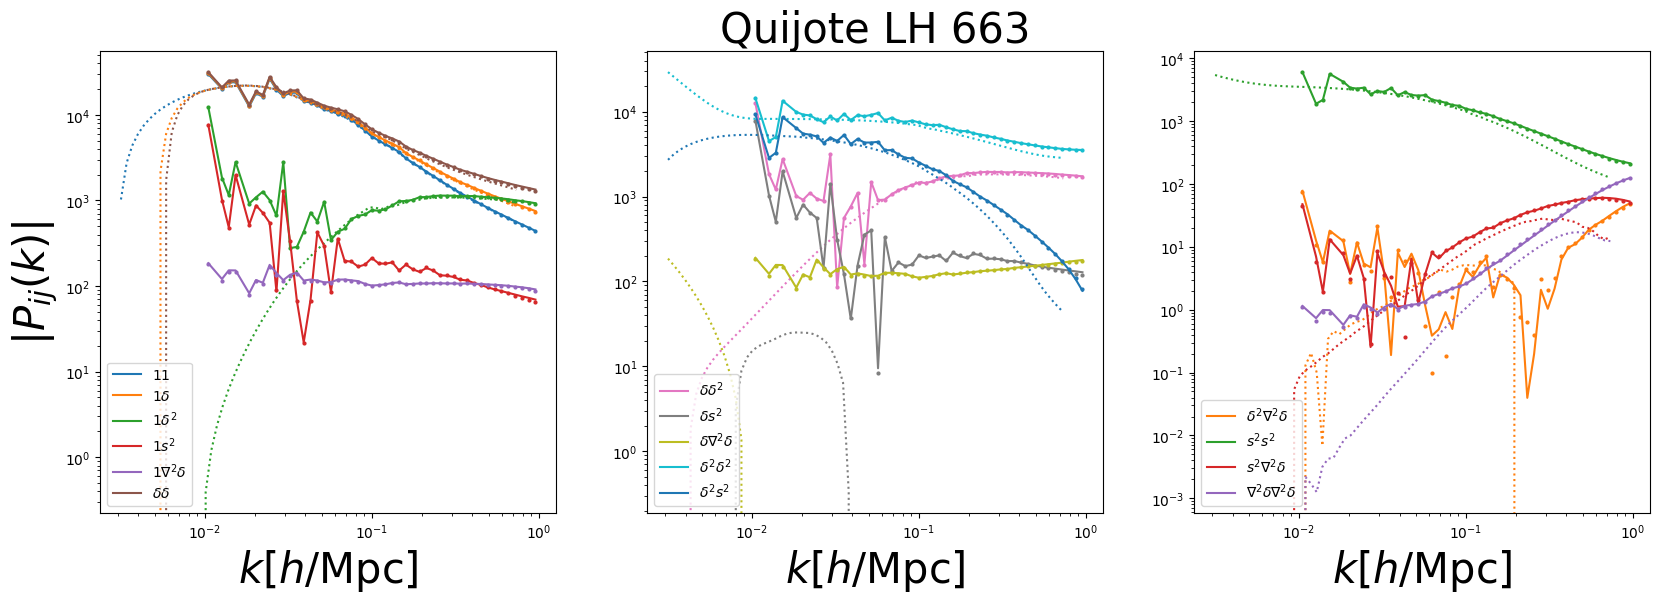

In [25]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

labels = ['$1 1$',
 '$1 \\delta$',
 '$1 \\delta^2$',
 '$1 s^2$',
 '$ 1 \\nabla^2\\delta$',
 '$\\delta \\delta$',
 '$\\delta \\delta^2$',
 '$\\delta s^2$',
 '$\\delta \\nabla^2\\delta$',
 '$\\delta^2 \\delta^2$',
 '$\\delta^2 s^2$',
 '$\\delta^2 \\nabla^2\\delta$',
 '$s^2 s^2$',
 '$s^2 \\nabla^2\\delta$',
 '$\\nabla^2\\delta \\nabla^2\\delta$']

indices = range(0,15)

contf=0
for ii in indices:
    mask = np.abs(power_all_terms_sim[ii]['pk'])>0
    ax[contf].loglog(power_all_terms_pred[ii]['k'][mask], np.abs(power_all_terms_pred[ii]['pk'][mask]),
                       color='C'+str(ii), label=labels[ii])
    ax[contf].loglog(power_all_terms_pred[ii]['k'][mask], np.abs(power_all_terms_sim[ii]['pk'][mask]),
                       'o', markersize=2, color='C'+str(ii))
    ax[contf].loglog(lt_k_emu, pnn_emu[ii], ls=':', color='C'+str(ii), 
                     )
    
    ax[contf].legend(loc='lower left', frameon=True, fancybox=True)
    ax[contf].set_xlabel(r'$k[h/$Mpc]', size=30)
    if ii%5==0 and ii>0:
        contf+=1

ax[0].set_ylabel(r'$ |P_{ij}(k)| $', size=30)
#ax[0].set_ylim(10.,1e5)

# ax[1].set_title(r'Fiducial: $z=0$, $\Omega_{\rm m}=0.3175$, $\Omega_{\rm b}=0.049$, $\sigma_8=0.834$, $H_0=67.11$, $n_s=0.96$',
#                  fontsize=30)
ax[1].set_title(f'Quijote LH {indicesLH[i]}',
                 fontsize=30)
plt.show()


### And that's it. Thanks for reading until here!

### Marcos :)

# Actually no! Now we combine with a given set of bias parameters :)

In [21]:
biases = [1, 0, 0, 0] # b1, b2, bs2, blap

bias_extended = np.concatenate([[1], biases])

prod = np.array(list(itertools.combinations_with_replacement(np.arange(5), r=2)))

sum_terms_power = 0
for ii in range(0,15):
    fac = 2 if prod[ii,0]!=prod[ii,1] else 1
    sum_terms_power += bias_extended[prod[ii,0]] * bias_extended[prod[ii,1]] * power_all_terms_pred[ii]['pk'] * fac

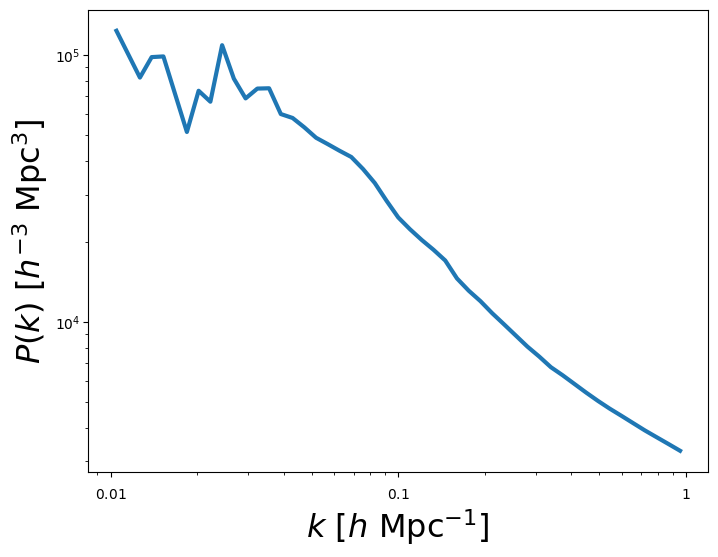

In [22]:
kk = power_all_terms_pred[0]['k']
sum_terms_power
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

mask = sum_terms_power > 0
ax.loglog(kk[mask], sum_terms_power[mask], lw=3)

ax.set_xlabel(r'$k \,\, [h \,\, \mathrm{Mpc}^{-1}]$', size=23)
ax.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, \mathrm{Mpc}^{3}]$', size=23)
bacco.set_logticks(ax)

plt.show()